In [5]:
import matplotlib.pyplot as plt
import numpy as np

***

### Создаём 2 класса рядов

In [6]:
duration = 4 # sec
N = 10
num_samples = 120
time_index = np.linspace(0, duration, num_samples)

TSDS = [[[], 0], [[], 1]]


# Группа косинусов
for i in range(N):
    TSDS[0][0].append(
        8*np.cos(0.6*np.pi*time_index + np.random.uniform(50, 100)) + (np.random.normal(0, 1, num_samples)*np.random.normal(1, 4, num_samples)*0.2*np.sin(np.pi*time_index))
    )

# Группа модифицированных синусов
for i in range(N):
    TSDS[1][0].append(
        15*np.sin(6*np.pi*np.sin(np.pi + time_index) + 2*np.random.uniform(1, 3)) + \
                              5*np.sin(2*np.pi*time_index + 3*np.random.uniform(2, 10)) + 10*(np.random.random() + 0.65) + \
                              + np.random.normal(1, 4, num_samples)*pow(2*np.cos(2*np.pi*time_index), 2)
    )

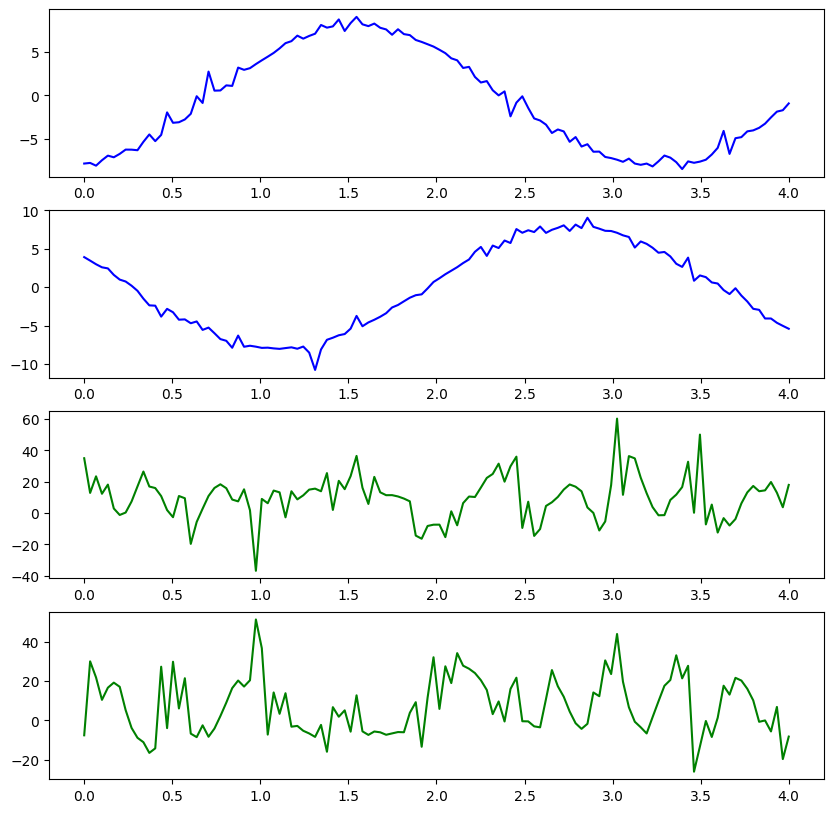

In [7]:
fig, axs = plt.subplots(4, 1,figsize=(10, 10))

axs[0].plot(time_index, TSDS[0][0][2], '-b')
axs[1].plot(time_index, TSDS[0][0][6], '-b')

axs[2].plot(time_index, TSDS[1][0][3], '-g')
axs[3].plot(time_index, TSDS[1][0][9], '-g')

***

### Алгоритм поиска шейплетов

In [8]:

def sum_one_to_n(n):
    return int(n * (n + 1) / 2)

def sum_k_to_n(k, n):
    return sum_one_to_n(n) - sum_one_to_n(k - 1)

In [9]:
def euclidean_distances(x, y):
    return np.sqrt(np.sum((x - y) * (x - y)))

def min_dist(x, y):
    return np.min([euclidean_distances(x, y[i:i + len(x)]) for i in np.arange(len(y) - len(x) + 1)])

In [10]:
def assess_quality(shapelet, ds, c):
    total = np.zeros(c)
    for ts in ds:
        total[ts[1]] += 1
    p_total = -np.sum([np.log(np.power(total[i] / len(ds), total[i] / len(ds))) for i in np.arange(len(total))])
    left = np.zeros(c)
    right = np.zeros(c)
    for ts in ds:
        right[ts[1]] += 1
    ig = p_total
    for i in range(1, len(ds)):
        left[ds[i - 1][1]] += 1
        right[ds[i - 1][1]] -= 1
        p_left = np.sum([np.log(np.power(left[i] / len(ds), left[i] / len(ds))) for i in np.arange(len(left))])
        p_right = np.sum([np.log(np.power(right[i] / len(ds), right[i] / len(ds))) for i in np.arange(len(right))])
        ig = max(ig, p_left * i / len(ds) + p_right * (len(ds) - i) / len(ds))
    return p_total + ig

In [11]:
class Shapelet:
    def __init__(self, values, left, right):
        self.values = values
        self.left = left
        self.right = right

def select_shapelets(arr, min, max):
    k = 0
    for ts_mark in arr:
        for ts in ts_mark[0]:
            k += sum_k_to_n(len(ts) - max + 1, len(ts) - min + 1)
    k = int(k * 0.001)
    print(f"Будет отобрано {k} шейплетов")
    k_shapelets = []
    c = len(arr)
    for ts_mark in arr:
        for cnt_ts, ts in enumerate(ts_mark[0]):
            shapelets = []
            ts_len = len(ts)
            for l in range(min, max + 1):
                for i in range(ts_len - l + 1):
                    shapelet = Shapelet(ts[i:i + l], i, i + l - 1)
                    ds = []
                    for i in range(len(arr)):
                        for j in range(len(arr[i][0])):
                            ds.append([min_dist(shapelet.values, arr[i][0][j]), arr[i][1]])
                    ds = sorted(ds, key=(lambda x: x[0]))
                    quality = assess_quality(shapelet.values, ds, c)
                    shapelets.append([quality, shapelet])
            print(f"Класс {ts_mark[1]}, ряд {cnt_ts+1}, отобрано шейплетов: {len(shapelets)}")
            shapelets = sorted(shapelets, key=(lambda x: -x[0]))
            i = 1
            ids = []
            for i in range(len(shapelets)):
                f = True
                for j in ids:
                    flr = shapelets[i][1].right <= shapelets[j][1].left
                    frl = shapelets[j][1].right <= shapelets[i][1].left
                    f = f and (frl or flr)
                    if not(f):
                        break
                if f:
                    ids.append(i)
            for i in ids:
                k_shapelets.append(shapelets[i])
    k_shapelets = sorted(k_shapelets, key=(lambda x: x[0]))[:k]
    return (lambda x: np.array([x[i][1].values for i in np.arange(len(x))]))(k_shapelets)

***

### Классификатор

In [18]:
from pyts.classification import TimeSeriesForest
from sklearn.metrics import confusion_matrix

In [13]:
shapelets_all = select_shapelets(TSDS, 15, 90)

Будет отобрано 104 шейплетов
Класс 0, ряд 1, отобрано шейплетов: 5206
Класс 0, ряд 2, отобрано шейплетов: 5206
Класс 0, ряд 3, отобрано шейплетов: 5206
Класс 0, ряд 4, отобрано шейплетов: 5206
Класс 0, ряд 5, отобрано шейплетов: 5206
Класс 0, ряд 6, отобрано шейплетов: 5206
Класс 0, ряд 7, отобрано шейплетов: 5206
Класс 0, ряд 8, отобрано шейплетов: 5206
Класс 0, ряд 9, отобрано шейплетов: 5206
Класс 0, ряд 10, отобрано шейплетов: 5206
Класс 1, ряд 1, отобрано шейплетов: 5206
Класс 1, ряд 2, отобрано шейплетов: 5206
Класс 1, ряд 3, отобрано шейплетов: 5206
Класс 1, ряд 4, отобрано шейплетов: 5206
Класс 1, ряд 5, отобрано шейплетов: 5206
Класс 1, ряд 6, отобрано шейплетов: 5206
Класс 1, ряд 7, отобрано шейплетов: 5206
Класс 1, ряд 8, отобрано шейплетов: 5206
Класс 1, ряд 9, отобрано шейплетов: 5206
Класс 1, ряд 10, отобрано шейплетов: 5206


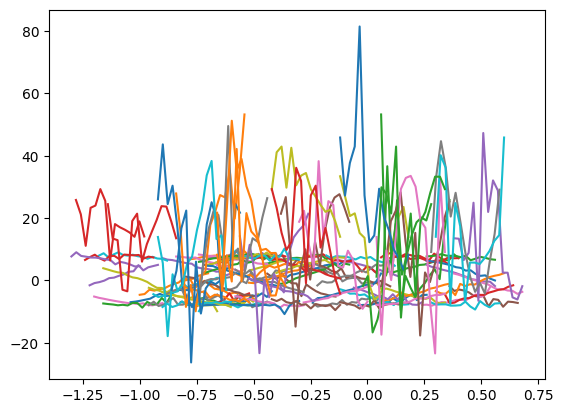

In [14]:
for s in shapelets_all:
    t = np.random.randint(100 - len(s))
    plt.plot(np.linspace((t - len(s) - 50) / 50, (t - 50) / 50, len(s)), s)
plt.show()

In [15]:
X = []
Y = []
ts = []

for x in TSDS[0][0]:
    ts.append(np.array([min_dist(s, x) for s in shapelets_all]))

for x in TSDS[1][0]:
    ts.append(np.array([min_dist(s, x) for s in shapelets_all]))

for i in range(len(ts)):
    X.append(ts[i])
    Y.append(i // 10)

X_train = []
X_test  = []
Y_train = []
Y_test  = []

indices = np.arange(len(Y))
np.random.shuffle(indices) 
for i in range(14):
    X_train.append(X[indices[i]])
    Y_train.append(Y[indices[i]])

for i in range(14, 20):
    X_test.append(X[indices[i]])
    Y_test.append(Y[indices[i]])


print(Y_train)
print(Y_test)

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
[0, 0, 1, 0, 0, 0]


In [16]:
model = TimeSeriesForest()
model.fit(X_train, Y_train)

TimeSeriesForest()

In [17]:
print(f"Accuracy = {model.score(X_test, Y_test)}")
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам: {model.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс: {Y_test[i]}\n")

Accuracy = 1.0
Вектор вероятности принадлежности к классам: [[0.99 0.01]]
Истинный класс: 0

Вектор вероятности принадлежности к классам: [[0.992 0.008]]
Истинный класс: 0

Вектор вероятности принадлежности к классам: [[0.016 0.984]]
Истинный класс: 1

Вектор вероятности принадлежности к классам: [[0.998 0.002]]
Истинный класс: 0

Вектор вероятности принадлежности к классам: [[0.992 0.008]]
Истинный класс: 0

Вектор вероятности принадлежности к классам: [[0.99 0.01]]
Истинный класс: 0

